# Measuring Fairness

The first step to addressing algorithmic bias is to be able to measure the degree of fairness (or lack thereof) in a given dataset. This chapter covers a number of commonly used fairness measures. For concreteness, we will demonstrate these fairness measures by calculating them on the [Compas Recidivism Dataset](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis).

```{admonition} Data: Compas Recidivism Dataset
:class: note
- Location: "data/recidivism/compas-scores-two-years.csv"
- Shape: (7214, 53)
- Source: ProPublica
```

The following script imports the dataset and prints the first few rows.

In [1]:
# import compas two-year dataset
import pandas as pd
compas = pd.read_csv('../data/recidivism/compas-scores-two-years.csv')
compas.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [2]:
# following the ProPublica analysis, we remove several rows with missing data
# see https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb for more details
compas = compas[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
compas = compas[(compas['days_b_screening_arrest'] <= 30) & 
                (compas['days_b_screening_arrest'] >= -30) &  
                (compas['is_recid'] != -1) &
                (compas['c_charge_degree'] != 'O') & 
                (compas['score_text'] != 'N/A')]
compas.shape

(6172, 13)

In [3]:
# finally, we focus on "race" as the protected attribute and African American vs. Caucasian as the two groups
compas = compas[compas['race'].isin(['African-American', 'Caucasian'])]
compas.shape

(5278, 13)

## Fairness Measures for Binary Classifier

To begin with, we consider measuring fairness of a classification model. In the ```Compas``` dataset, the ```score_text``` columns contains model-predicted risk level (low, medium, high) and the ```two_year_recid``` column contains the actual two-year recidivism label (1, 0). Because the outcome label is binary, we focus on the "low" and "high" predicted classes here.

In [4]:
compas_binary = compas.copy()
# remove "medium" in score_text
compas_binary = compas_binary[compas_binary['score_text'] != 'Medium']

Throughout this chapter, we adopt the following notations in formal definitions of different fairness measures:

```{admonition} Notations
:class: tip
- $Y$: actual outcome (0/1, recidivism without two years or not);
- $\widehat{Y}$: predicted risk score ("High" or "Low");
- $p$: predicted probability of being "High" risk;
- $R$: race, protected attribute of interested in this example. $R \in \{AA, W\}$ represents African American and Caucasian respectively;
- $\boldsymbol{X}$: other observable characteristics (e.g., gender, age, prior offenses).
```

### Statistical Parity

**Statistical parity** is one of the most straightforward fairness measures. It simply asserts that one group should not receive systematically more favorable predicted outcomes than the other group. Despite its simplicity, it has been extensively used / discussed in the prior literature, such as {cite:t}`calders2010three,calders2009building,kamiran2009classifying,kamishima2011fairness`, among many others.

In the context of recidivism prediction, with the protected attribute being race and the two groups to be compared being African American vs. White, statistical parity can be defined as:

```{admonition} Definition: Statistical Parity for Binary Classifier
:class: tip
$$
\Pr(\widehat{Y} = High | R = AA) = \Pr(\widehat{Y} = High | R = W)
$$
```

In [5]:
# evaluate statistical parity
# percentage of "high" scores among African Americans
AA_pct = len(compas_binary[(compas_binary['score_text'] == 'High') & (compas_binary['race'] == 'African-American')]) / len(compas_binary[compas_binary['race'] == 'African-American'])
# percentage of "high" scores among Whites
W_pct = len(compas_binary[(compas_binary['score_text'] == 'High') & (compas_binary['race'] == 'Caucasian')]) / len(compas_binary[compas_binary['race'] == 'Caucasian'])
print("Percentage of 'high' predicted scores among African Americans: ", AA_pct)
print("Percentage of 'high' predicted scores among Whites: ", W_pct)

Percentage of 'high' predicted scores among African Americans:  0.38566864445458693
Percentage of 'high' predicted scores among Whites:  0.13680981595092023


As we can see, around 38.6\% of African American defendents received high-risk predictions whereas only 13.7\% of White defendents received high-risk predictions. This is a violation of statistical parity.

### Conditional Statistical Parity

Statistical parity is a rather crude measure and, specifically, does not take into account any systematic differences across the two groups that may explain some of the disparity in predicted outcomes. **Conditional Statistical Parity** seeks to amend this issue by conditioning on other observable characteristics. It has also been discussed in prior literature, including for example, {cite:t}`vzliobaite2011handling,kamiran2013quantifying`.

```{admonition} Definition: Conditional Statistical Parity for Binary Classifier
:class: tip
$$
\Pr(\widehat{Y} = High | R = AA, \boldsymbol{X}) = \Pr(\widehat{Y} = High | R = W, \boldsymbol{X})
$$
```

In [25]:
# evaluate conditional statistical parity
# following ProPublica's analysis, X may contain: age, gender, number of prior offenses, and severity of charge
# they can be used as control variables in a logistic regression of predicted risk score on race
import statsmodels.formula.api as smf
# convert score_text to 1 and 0
compas_binary['Y'] = compas_binary['score_text'].apply(lambda x: 1 if x == 'High' else 0)
model = smf.logit(formula = "Y ~ race + age + sex + priors_count + c_charge_degree", data = compas_binary).fit()
model.summary()


Optimization terminated successfully.
         Current function value: 0.360191
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 3821
Model:                          Logit   Df Residuals:                     3815
Method:                           MLE   Df Model:                            5
Date:                Tue, 07 May 2024   Pseudo R-squ.:                  0.3921
Time:                        15:22:57   Log-Likelihood:                -1376.3
converged:                       True   LL-Null:                       -2263.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.5816      0.224     11.531      0.000       2.143       3.020
race[T.Caucasian]       -0.6532      0.105     -6.229      0.000      -0.859      -0.448
sex[T.Male]             -0.0371      0.128     -0.290      0.772      -0.288       0.214
c_charge_degree[T.M]    -0.4953      0.106     -4.682      0.000      -0.703      -0.288
age                     -0.1396      0.007    -19.506      0.000      -0.154      -0.126
priors_count             0.3782      0.016     23.279      0.000       0.346       0.410
========================================================================================
"""

We can see that even after controlling for age, gender, prior offenses and the severity of charge, being African American still significantly increased the odds of receiving high-risk predictions. This is a violation of conditional statistical parity.

### Error Balance / Equalized Odds

Statistical parity (with or without conditioning on other observable characteristics) aims to balance the predicted outcomes of two groups. Fairness measures like these reflect the _Equal Outcome_ ideal. In contrast, many other fairness measures are designed to reflect the _Equal Opportunity_ ideal (that different groups are treated equally, even though their outcomes may differ). **Error Balance** or **Equalized Odds** is one of such measures.

Roughly speaking, error balance asserts that a classifier should not be systematically more inaccurate for one group vs. the other group. Specifically, one way to quantify it is to check whether the false positive rate and false negative rate are the same for the two groups. More formally,

```{admonition} Definition: Error Balance / Equalized Odds
:class: tip
\begin{align*}
\Pr(\widehat{Y} = High | R = AA, Y = 0) & = \Pr(\widehat{Y} = High | R = W, Y = 0) \\
\Pr(\widehat{Y} = Low | R = AA, Y = 1) & = \Pr(\widehat{Y} = Low | R = W, Y = 1)
\end{align*}
```

In [7]:
# evaluate FPR and FNR for both groups
FPR_AA = len(compas_binary[(compas_binary['score_text'] == 'High') & (compas_binary['race'] == 'African-American') & (compas_binary['is_recid'] == 0)]) / len(compas_binary[(compas_binary['race'] == 'African-American') & (compas_binary['is_recid'] == 0)])
FNR_AA = len(compas_binary[(compas_binary['score_text'] == 'Low') & (compas_binary['race'] == 'African-American') & (compas_binary['is_recid'] == 1)]) / len(compas_binary[(compas_binary['race'] == 'African-American') & (compas_binary['is_recid'] == 1)])
FPR_W = len(compas_binary[(compas_binary['score_text'] == 'High') & (compas_binary['race'] == 'Caucasian') & (compas_binary['is_recid'] == 0)]) / len(compas_binary[(compas_binary['race'] == 'Caucasian') & (compas_binary['is_recid'] == 0)])
FNR_W = len(compas_binary[(compas_binary['score_text'] == 'Low') & (compas_binary['race'] == 'Caucasian') & (compas_binary['is_recid'] == 1)]) / len(compas_binary[(compas_binary['race'] == 'Caucasian') & (compas_binary['is_recid'] == 1)])
# print results
print("False Positive Rate for African Americans: ", FPR_AA)
print("False Negative Rate for African Americans: ", FNR_AA)
print("False Positive Rate for Whites: ", FPR_W)
print("False Negative Rate for Whites: ", FNR_W)

False Positive Rate for African Americans:  0.18793273986152326
False Negative Rate for African Americans:  0.4449152542372881
False Positive Rate for Whites:  0.0549558390578999
False Negative Rate for Whites:  0.7266775777414075


Here, we see that the predicted risk is systematically more inaccurate for African Americans in the undesirable direction. Specifically, the model makes more false positive mistakes (i.e., misclassify a low-risk defendent as high-risk) for African Americans but makes more false negative mistakes (i.e., misclassify a high-risk defendent as low-risk) for Whites. In fact, this is one of ProPublica's main arguments to show the unfairness of COMPAS {cite:p}`angwin2016machine`.

Just like in the case of statistical parity, you can further condition on other observables to construct a **conditional** version of error balance / equalized odds. Technically speaking, this amounts to running a logistic regression with (i) observed characteristics and (ii) the actual recidivism labels as control variables.

In [12]:
# evaluate conditional error balance / equalized odds
import statsmodels.formula.api as smf
# convert score_text to 1 and 0
compas_binary['Y'] = compas_binary['score_text'].apply(lambda x: 1 if x == 'High' else 0)
model = smf.logit(formula = "Y ~ race + age + sex + priors_count + c_charge_degree + is_recid", data = compas_binary).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.350152
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 3821
Model:                          Logit   Df Residuals:                     3814
Method:                           MLE   Df Model:                            6
Date:                Thu, 09 May 2024   Pseudo R-squ.:                  0.4090
Time:                        11:03:46   Log-Likelihood:                -1337.9
converged:                       True   LL-Null:                       -2263.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.9112      0.236      8.111      0.000       1.449       2.373
race[T.Caucasian]       -0.6357      0.107     -5.965      0.000      -0.845      -0.427
sex[T.Male]             -0.1420      0.131     -1.082      0.279      -0.399       0.115
c_charge_degree[T.M]    -0.5019      0.107     -4.669      0.000      -0.713      -0.291
age                     -0.1280      0.007    -17.951      0.000      -0.142      -0.114
priors_count             0.3429      0.016     21.095      0.000       0.311       0.375
is_recid                 0.8904      0.103      8.686      0.000       0.690       1.091
========================================================================================
"""

It is worth mentioning that another way to define error balance makes use of **predicted probabilities** rather than class predictions. It seeks to equalize the expected predicted probabilities of different groups conditioning on true labels (see, for example, {cite:t}`kleinberg2016inherent`). More formally,

```{admonition} Definition: Error Balance / Equalized Odds (with predicted probabilities)
:class: tip
\begin{align*}
\mathbb{E}(p | R = AA, Y = 0) & = \mathbb{E}(p | R = W, Y = 0) \\
\mathbb{E}(p | R = AA, Y = 1) & = \mathbb{E}(p | R = W, Y = 1)
\end{align*}
```

In [10]:
# evaluate error balance with predicted probabilities
# we will use "decile_score" to approximate the predicted probability of recidivism
# COMPAS predicts "High" risk when decile score is greater than 7 and "Low" if the decile score is lower than 5
# print average decile_score for African Americans and Whites
AA_0_avg = compas_binary[(compas_binary['race'] == 'African-American') & (compas_binary['is_recid'] == 0)]['decile_score'].mean()
AA_1_avg = compas_binary[(compas_binary['race'] == 'African-American') & (compas_binary['is_recid'] == 1)]['decile_score'].mean()
W_0_avg = compas_binary[(compas_binary['race'] == 'Caucasian') & (compas_binary['is_recid'] == 0)]['decile_score'].mean()
W_1_avg = compas_binary[(compas_binary['race'] == 'Caucasian') & (compas_binary['is_recid'] == 1)]['decile_score'].mean()
# print results
print("Average decile score for African Americans who did not recidivate: ", AA_0_avg)
print("Average decile score for African Americans who recidivated: ", AA_1_avg)
print("Average decile score for Whites who did not recidivate: ", W_0_avg)
print("Average decile score for Whites who recidivated: ", W_1_avg)

Average decile score for African Americans who did not recidivate:  3.4896142433234423
Average decile score for African Americans who recidivated:  6.188135593220339
Average decile score for Whites who did not recidivate:  2.334641805691855
Average decile score for Whites who recidivated:  4.11620294599018


Again, we see that the model systematically assigned higher decile scores to African Americans who did not recidivate, but lower scores to Whites who did recidivate.

### Calibration

Equal calibration represents another fairness measure that relies on predicted probabilities. It refers to a property of classification models, known as **calibration**, which requires the predicted probabilities to be "accurate" in the sense that they reflect the actual event rate. For example, suppose a well-calibrated model assigns a predicted probability of 70\% (of being in positive class) to 10 data points, then you would expect 7 out of those data points to actually belong to the positive class. Calibration is a desierable property because it allows users to intuitively interpret the predicted probabilities as actual event rates. Conversely, predicted probabilities from a poorly calibrated model may systematically overestimate or underestimate the actual event rates.

Adapting the notion of calibration for fairness measurement, we say that a classifier achieves equal calibration if predictions from the two groups are both well-calibrated. More formally,

```{admonition} Definition: Equal Calibration
:class: tip
$$
\mathbb{E}(Y | p, R = AA) = \mathbb{E}(Y | p, R = W) = p
$$
```

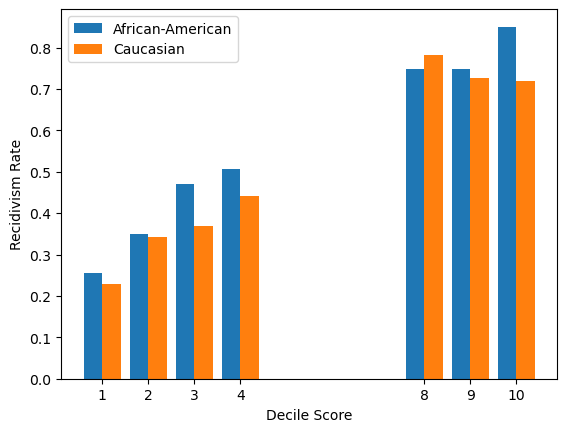

In [20]:
# evaluate calibration
# we will again use decile_score as the predicted probability of recidivism
# we will visualize the percentage of recidivism for each decile score and racial group
import matplotlib.pyplot as plt
# group by decile score and race, then calculate the average value of is_recid
calibration = compas_binary.groupby(['decile_score', 'race'])['is_recid'].mean().reset_index()
X = calibration['decile_score'].unique()
Y_AA = calibration[calibration['race'] == "African-American"]['is_recid']
Y_W = calibration[calibration['race'] == "Caucasian"]['is_recid']
# plot average recidivism rate for each decile score and the two groups
width = 0.4
plt.bar(X, Y_AA, width, label = "African-American")
plt.bar(X + width, Y_W, width, label = "Caucasian")
plt.xlabel("Decile Score")
plt.ylabel("Recidivism Rate")
plt.xticks(X + width / 2, X)
plt.legend()
plt.show()

Interestingly, we see that the average recidivism rates across different deciles are somewhat similar between the two groups. Among low-risk deciles, the model seems to underestimate the actual recidivism risks for both groups. Among high-risk deciles, it seems to overestimate the risks. Overall, we do not see a very clear pattern and in fact, this is one of COMPAS' counter-arguments to ProPublica, i.e., their risk tool is similarly calibrated for both racial groups {cite:p}`dieterich2016compas`.